<a href="https://colab.research.google.com/github/joubertt/dog-breeds/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Milestone Project 3**

*Dog Breed classification in Google Colab*



This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 & TensorFlow Hub

## 1. Problem
Identifying dog breed given the image of a dog.

## 2. Data
Data obtained from Kaggle dog breed identification problem: https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.

For each image in the test set, you must predict a probability for each of the different breeds.
https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

##4. Features
* We're dealing with images, aka unstructured data, hence it's best to use deep learning/ transfer learning.
* There are 120 different dog breeds, hence 120 different classes.
* There are ~10,000 labelled images in the training set.
* There are ~10,000 images in the test set for which we must predict the labels.

**Mount Google Drive**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Unzip data file**

In [8]:
#!unzip "/content/drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "/content/drive/MyDrive/Dog Vision2/"

**Import the relevant libraries & get workspace ready**

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
print('TF Hub version:', hub.__version__)
print('TF version: ', tf.__version__)

# Check for GPU availability
print('GPU', 'available (YESS!!!)' if tf.config.list_physical_devices else 'not available :(')

TF Hub version: 0.12.0
TF version:  2.11.0
GPU available (YESS!!!)


**Getting our data ready**

Let's start by importing & exploring our data

In [10]:
import pandas as pd
labels_csv = pd.read_csv('/content/drive/MyDrive/Dog Vision2/labels.csv')
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [11]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [12]:
# Determine how many images there are for each breed
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

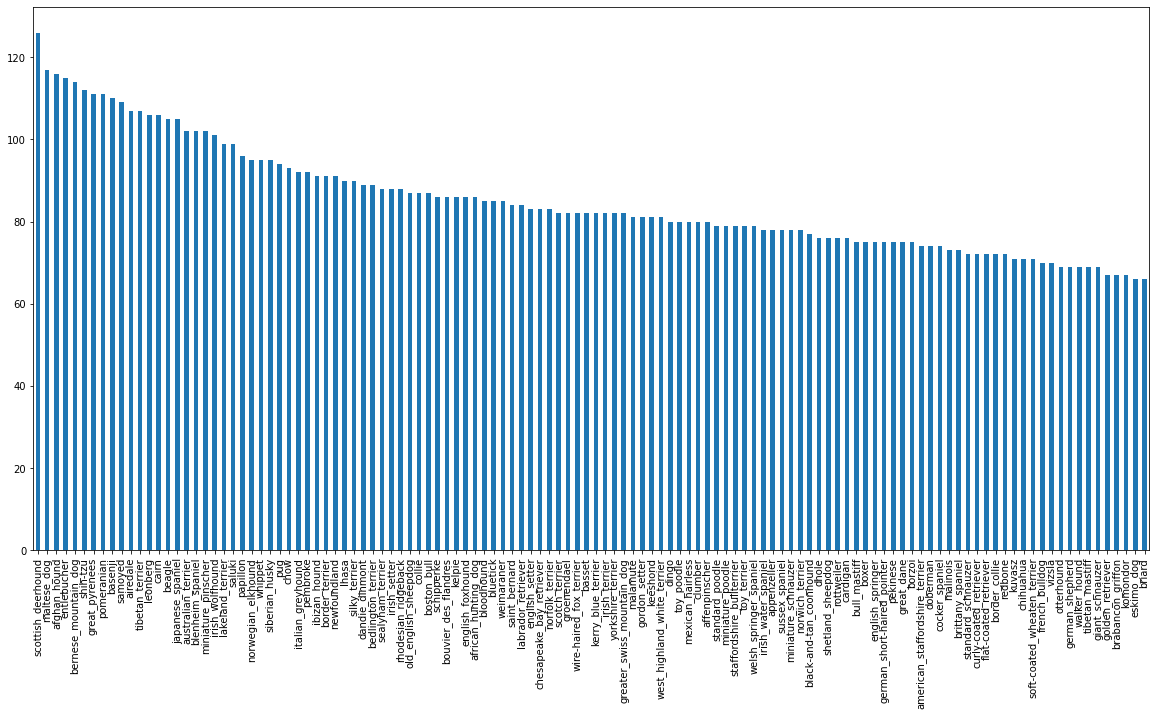

In [13]:
labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10))

In [14]:
labels_csv['breed'].value_counts().median()

82.0

In [15]:
labels_csv['breed'].value_counts().min()

66

**Viewing images**

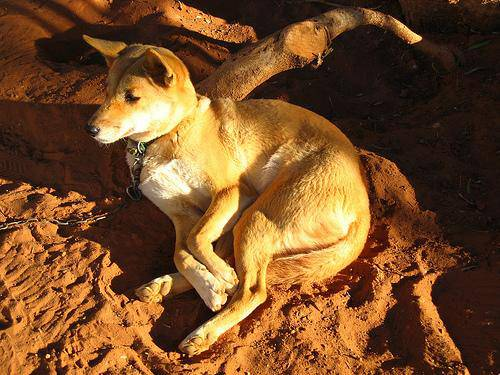

In [16]:
from IPython.display import Image
Image('/content/drive/MyDrive/Dog Vision2/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

**Getting images & their labels**

Let's get a list of all our image file pathnames


In [17]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [18]:
# Create pathnames from image ID's
filenames = ['/content/drive/MyDrive/Dog Vision2/train/'+ fname + '.jpg' for fname in labels_csv['id']]

# Check first 10 filenames
filenames[:10]

['/content/drive/MyDrive/Dog Vision2/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog Vision2/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog Vision2/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog Vision2/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog Vision2/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Dog Vision2/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Dog Vision2/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Dog Vision2/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Dog Vision2/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Dog Vision2/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [19]:
# Check the actual number of image files in the train folder
import os

lst = os.listdir('/content/drive/MyDrive/Dog Vision2/train') # your directory path
number_files = len(lst)
print(number_files)

10222


In [20]:
# Check whether number of filenames are equal to actual image files
if len(os.listdir('/content/drive/MyDrive/Dog Vision2/train')) == len(filenames):
  print('Filenames match actual amount of image files')
else:
  print('Filenames do NOT match actual amount of image files')

Filenames match actual amount of image files


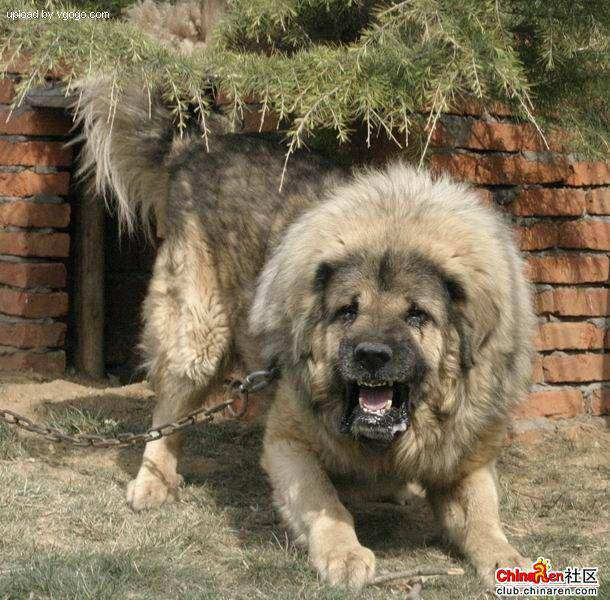

In [21]:
# One more check
Image(filenames[9000])

In [22]:
labels_csv['breed'][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels

In [23]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [24]:
len(labels)

10222

In [25]:
# Check for missing data again by checking if number of labels match number of filenames
if len(labels) == len(filenames):
  print('Number of labels matches number of filenames')
else:
  print('Oops, missing data')

Number of labels matches number of filenames


In [26]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [27]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds 

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [28]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [29]:
len(boolean_labels)

10222

In [30]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

This is done since Kaggle didn't provide us with one.


In [31]:
# Setup x and y variables
x = filenames
y = boolean_labels

In [32]:
# We're going to start off experimenting with ~1000 images & increase as needed

In [33]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:'slider', min:1000, max:10000, step:1000}

In [34]:
# Let's split our data into train & validation sets
from sklearn.model_selection import train_test_split

# Split them into training & validation of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(x_train), len(y_train), len(x_val), len(y_val)

(800, 800, 200, 200)

In [35]:
# Let's have a look at the training data
x_train[:5], y_train[:2]

(['/content/drive/MyDrive/Dog Vision2/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/Dog Vision2/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/content/drive/MyDrive/Dog Vision2/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '/content/drive/MyDrive/Dog Vision2/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '/content/drive/MyDrive/Dog Vision2/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
        

Preprocess images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TesnorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image` 

In [36]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """ 
  Takes an image file path and turns in into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn jpg into numerical Tensor with 3 colour channels (red, green, blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

Turning data into batches

Why turn data into batches?
* To save memory
* We usually do about 32 images at a time

In order to use TensorFlow effectively, we need our data in the form of tuples which looks like this: `(image, label)`

In [37]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  process the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [38]:
# Demonstration of the above function
process_image(x[42]), tf.constant(y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

### Creating batches

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all our data |(`x` and `y`) into batches

In [39]:
# Define the batch size
BATCH_SIZE = 32

# Create a function to turn data into batched
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data, but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test data set, we probably don't have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a validation dataset, we don't need to shuffle it
  elif valid_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print('Creating training data batches...')
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))
    
    # Create (image, label) tuples (this also turns the image into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [40]:
# Creating training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [41]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [42]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

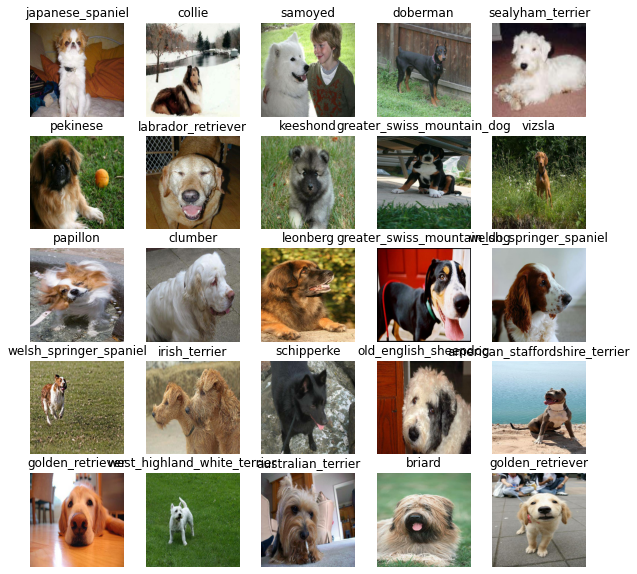

In [43]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

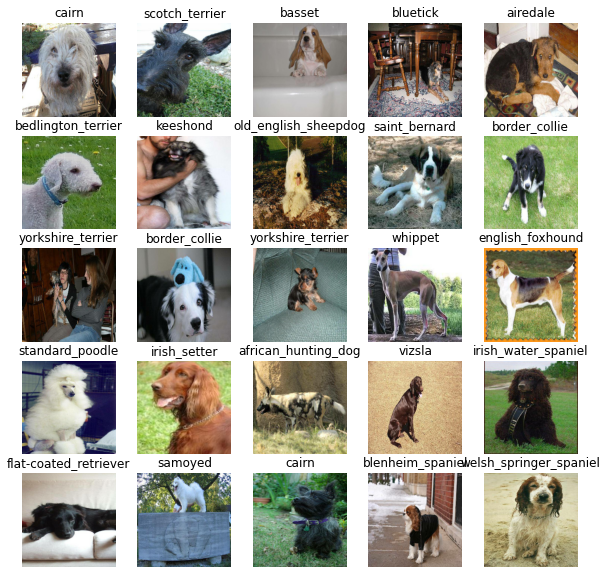

In [44]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:
1. The input shape (our images shape, in the form of Tensors) to our model_selection
2. The output shape (image labels, in the form of Tensors) of our model.
3. The URL of the model we want to use (we're going to use an existing model and optimize it) from TesnorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [45]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TesnorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5'

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model.

Knowing this, let's create a function which:
* Takes the input shape, output shape, & model we've chosen as parameters.
* Defines the layers in a Keras model in a sequential manner (do this 1st, then this, then that)
* Compiles the model (says how it should be avaluated & improved)
* Builds the model (tells the model the input shape it will be getting)
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [46]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model

In [47]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Create callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks:
* One for TensorBoard which helps track our models progress.
* Another for early stopping which prevents our model from training for too long.

### TensorBoard Callback
To setup a TesnorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory & pass it to our model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training). 

In [48]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [49]:
import datetime
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join('/content/drive/MyDrive/Dog Vision2/log',
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping callback

Early stopping helps stop our model from overfitting by stopping training if a certain ,etric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [50]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  patience=3)

## Training a model (on subset of the data)

Our 1st model is only going to train on 1000 images to make sure everything is working.

In [51]:
NUM_EPOCHS = 100 #@param {type:'slider', min:10, max:100, step:10}

In [52]:
# Check for GPU
print('GPU', 'available (YESSSS!!)' if tf.config.list_physical_devices('GPU') else 'not available :(')

GPU not available :(


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model, passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use.
* Return model

In [53]:
# Build a function to train & return a trained model
def train_model():
  """
  Trains a given model and returns the trained version
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [ ]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 557s 23s/step - loss: 4.6156 - accuracy: 0.0988 - val_loss: 3.3909 - val_accuracy: 0.2250
Epoch 2/100
 6/25 [======>.......................] - ETA: 45s - loss: 2.2661 - accuracy: 0.5521

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

In [ ]:
%tensorboard --logdir drive/MyDrive/Dog\ Vision2/log

## Making & evaluating predictions using a trained model


In [ ]:
# Make predictions on the validation data
predictions = model.predict(val_data,verbose=1)
predictions

In [ ]:
predictions.shape

### Interpreting the predictions

In [ ]:
# First predicition
predictions[0]

In [ ]:
index = 42
print(predictions[index])
print(f'Max value (probability of prediction): {np.max(predictions[index])}')
print(f'Sum: {np.sum(predictions[index])}')
print(f'Max index: {np.argmax(predictions[index])}')
print(f'Predicted label: {unique_breeds[np.argmax(predictions[index])]}')

Having the above functionality is great, but we would like to be able to do it at scale.

And it would be great if we could see the image the prediction is being made on.

**Note:**
Prediction probabilities are also known as confidence intervals.

In [ ]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediciton probabilities int a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[2])
pred_label

Now since our validation data is still in a batch dataset, we will have to unbatch it to make predictions on the validation images and then compare those predictions to the validation lables (truth labels)

In [ ]:
# Create a function to unbatch a batched dataset

def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors & returns separate arrays of images & labels.
  """
  images_ = []
  labels_ = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(unique_breeds[np.argmax(label)])
  return images_, labels_

# Unbatch the validation data
val_images, val_labels = unbatchify(val_data)
val_images[1], val_labels[1]

Nailed it!

Now we've got ways to get:

Prediction labels
Validation labels (truth labels)
Validation images
Let's make some functions to make these all a bit more visual.

More specifically, we want to be able to view an image, its predicted label and its actual label (true label).

The first function we'll create will:

* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  
  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = 'green'
  else:
    color = 'red'

  # Change plot title to be predicted, probability pf prediction and truth label
  plt.title('{} {:2.0f}% {}'.format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)


In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=1)

### Top 10 predictions

Now we've got one function to visualize our models' top prediction, let's make another to view our model's top 10 predictions

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer
* Find the prediction using `get_pred_label()`
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 highest prediction confidences along with the truth label for sample n
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction ocnfidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color='grey')
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation='vertical')
  
  # Change the colour of the true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
  else:
    pass
  

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=1)

The figure above gives the top 10 predictions for image n=1, which is a Scottish terrier. The model did predict the dog breed correctly.

Now we've got some functions to help us visualize our predictions,  let's check out a few.

In [ ]:
# Let's check out a few pedictions and their different values
i_multiplier = 40
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)

plt.tight_layout(h_pad=1.0)
plt.show()

### Save and load a trained model

In [ ]:
# Create a function to save a trained model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory snd appends a suffix (string)
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join('/content/drive/MyDrive/Dog Vision2/models', 
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
  model_path = modeldir + '-' + suffix + '.h5' # .h5 is the file type of the model
  print(f'Saving model to: {model_path}...')
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f'Loading saved model from: {model_path}')
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={'KerasLayer':hub.KerasLayer})
  return model

Now we've got functions to load and save a trained model, let's make sure they work

In [ ]:
# Save our model trained on a 1000 images
save_model(model, suffix='1000-images-mobilenetv2-Adam')

In [ ]:
# Load a trained model
loaded_1000_image_model = load_model('/content/drive/MyDrive/Dog Vision2/models/20230216-06221676528530-1000-images-mobilenetv2-Adam.h5')

### Evaluate the pre-saved model

In [ ]:
model.evaluate(val_data)

### Evaluate the loaded model

In [ ]:
loaded_1000_image_model.evaluate(val_data)

### Train model on FULL dataset

#### Create a data batch with the full dataset using previously created batch function

In [ ]:
full_data = create_data_batches(x, y)

In [ ]:
full_data

#### Create a model for full dataset

In [ ]:
full_model = create_model()

#### Create full model callbacks

In [ ]:
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, hence we cannot monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                             patience=3)

**Note:** Running the cell below will take a while since we are training the model on the full dataset using a GPU

In [ ]:
%tensorboard --logdir drive/MyDrive/Dog\ Vision2/log

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard,
                          full_model_early_stopping])

#### Save model trained on full dataset

In [ ]:
save_model(full_model, suffix='full-image-set-mobilenetv2-Adam')

#### Load model trained on full dataset

In [ ]:
loaded_full_model = load_model('/content/drive/MyDrive/Dog Vision2/models/20230216-06381676529486-full-image-set-mobilenetv2-Adam.h5')

### Making predictions on the test dataset using model trained on FULL training dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test datam we will have to get it into the same format.

Luckily we created `create_data_batches()` earlier, which can take a list of filenames as input an convert them into Tensor batches.

To make predictions on the ttest data, we will:
* Get the test image filenames
* Convert the filenames into test batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels)
* Make a predictions array by passing the test batches to the `predict()` method called on our model



#### Load the test image filenames

In [ ]:
test_path = 'drive/MyDrive/Dog Vision2/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

In [ ]:
len(test_filenames)

#### Convert test data batch

In [ ]:
test_data = create_data_batches(test_filenames, test_data=True)

In [ ]:
test_data

#### Make predictions on test data batch using loaded FULL model

In [ ]:
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

#### Save predictions (NumPy array) to csv file (for later access)

In [ ]:
np.savetxt('drive/MyDrive/Dog Vision2/preds_array.csv', test_predictions, delimiter=',')

#### Load predictions (NumPy array) from csv file

In [ ]:
test_predictions = np.loadtxt('drive/MyDrive/Dog Vision2/preds_array.csv', delimiter=',')

In [ ]:
test_predictions[:10]

In [ ]:
test_predictions.shape

### Sample submission to Kaggle

Looking at the [Kaggle sample submission](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation), it looks like they want the models output probabilities each for label along with the image ID's.

To get the data in this format, we'll:
*   Create a pandas DataFrame with an ID column as well as a column for each dog breed.
*   Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns using the `unique_breeds` list and the `test_predictions` list.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [ ]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=['id'] + list(unique_breeds))
preds_df.head()

In [ ]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df['id'] = test_ids

In [ ]:
preds_df.head()

In [ ]:
# Append prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

In [ ]:
# Export DataFrame to CSV for submission to Kaggle
preds_df.to_csv('drive/MyDrive/Dog Vision2/full_model_predictions_submission_1_mobilenetV2.csv', index=False)

In [ ]:
# Upload to Kaggle

## Making predictions on custom images

It's great being able to make predictions on a test dataset already provided for us.

But how could we use our model on our own images?

The premise remains, if we want to make predictions on our own custom images, we have to pass them to the model in the same format the model was trained on.

To do so, we'll:

Get the filepaths of our own images.
* Turn the filepaths into data batches using create_data_batches()
* And since our custom images won't have labels, we set the test_data parameter to True.
* Pass the custom image data batch to our model's predict() method
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.

Note: To make predictions on custom images, I've uploaded pictures of my own to a directory located at drive/My Drive/Data/dogs/ (as seen in the cell below). In order to make predictions on your own images, you will have to do something similar.

In [ ]:
# Get the custom image filepaths
custom_path = 'drive/MyDrive/Dog Vision2/custom-dog-images/'
custom_image_paths = [custom_path + fname fro fname in os.listdir(custom_path)]

In [ ]:
custom_image_paths